In [1]:
import numpy
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("dataset/train_data.csv")

In [67]:
df.YEAR.value_counts()

2017/18    6088
2018/19    5861
Name: YEAR, dtype: int64

In [4]:
df.columns

Index(['BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'POSTCODE', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'Borough', 'Latitude',
       'Longitude', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'NTA', 'New Georeferenced Column'],
      dtype='object')

# Data preprocessing

In [31]:
clusters = pd.read_csv("clusters.csv")
clusters = clusters.set_index("labels")

In [32]:
def find_closest_cluster(point, clusters):
    if np.sum(np.isnan(point)) > 0:
        return -1, 0
    dist = np.sqrt(np.sum((clusters - point)**2, axis=1))
    ind = np.argmin(dist)
    min_dist = np.min(dist)
    return ind, min_dist

In [33]:
def df_info(df):
    #print(df.info())
    return df

In [34]:
def select_columns(df, columns=[]):
    """
    Selects columns from `columns`
    """
    return df.loc[:,columns]

In [35]:
def encode_easement(df):
    df.EASEMENT = df.EASEMENT.apply(lambda x: int(len(str(x)) == 1))
    return df

In [36]:
def fix_stories(df):
    df.STORIES.fillna(0, inplace=True)
    return df

In [37]:
def calculate_dist(df):
    cl = []
    dist = []
    for point in zip(df.Latitude, df.Longitude):
        point = np.array(point)
        ind, mdis = find_closest_cluster(point, clusters=clusters)
        cl += [ind]
        dist += [mdis]
    df["cluster"] = cl
    df["dist"] = dist
    return df

In [38]:
def drop_columns(df, columns=["EASEMENT", "Latitude", "Longitude", "EXLAND", "EXTOT", "STORIES", "cluster"]):
    df = df.drop(columns=columns)
    return df

In [39]:
result = df.pipe(df_info) \
  .pipe(select_columns, columns=
          [
           "BORO",
           "EASEMENT",
           "TAXCLASS",
           "LTFRONT",
           "Latitude",
           "Longitude",
           "LTDEPTH",
           "AVTOT",
           "EXLAND",
           "EXTOT",
           "STORIES",
           "YEAR",
           "FULLVAL", # Y
           #"NTA",
           #"NTA_VAL",
           #"BORO_VAL",
           #"BLOCK_VAL"
          ]) \
  .pipe(fix_stories) \
  .pipe(encode_easement) \
  .pipe(calculate_dist) \
  .pipe(drop_columns)

In [15]:
result.columns

Index(['BORO', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'AVTOT', 'YEAR', 'FULLVAL',
       'dist'],
      dtype='object')

# Model training and predictions

In [40]:
threshold = 0.1e6

In [41]:
from pycaret.regression import *

In [42]:
smol = result[result.AVTOT < threshold]

In [43]:
s = setup(smol, target = 'FULLVAL')

,Description,Value
0,session_id,7684
1,Target,FULLVAL
2,Original Data,"(9029, 8)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6320, 20)"


In [44]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,94399.4168,79551497060.1478,278786.9013,0.7589,0.6619,0.2097,0.1140
gbr,Gradient Boosting Regressor,111509.4122,79012548203.1951,278401.9133,0.7589,1.7427,0.8676,0.0650
lightgbm,Light Gradient Boosting Machine,108089.4911,81284743602.1583,283171.7194,0.7508,1.7038,0.5244,0.0180
et,Extra Trees Regressor,94086.1672,83457588025.7356,286405.4245,0.7455,0.4938,0.2072,0.0870
dt,Decision Tree Regressor,120313.7867,145557142278.4436,376184.8967,0.5606,0.5042,0.2044,0.0110
llar,Lasso Least Angle Regression,203919.5107,156721134744.0607,393670.4815,0.5248,2.2058,5.3848,0.2260
lr,Linear Regression,203966.9033,156780008372.6383,393738.5638,0.5247,2.2064,5.3898,0.2430
lasso,Lasso Regression,203945.5100,156804837195.9189,393765.4749,0.5246,2.2071,5.3917,0.1810
br,Bayesian Ridge,202882.1251,156945059565.4381,393933.8473,0.5242,2.2083,5.5626,0.1450
ridge,Ridge Regression,202559.0933,158375332699.2725,395732.9324,0.5199,2.2116,5.9313,0.1570


In [45]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Save model 

In [46]:
finalize_model(best)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=7684, verbose=0, warm_start=False)

In [48]:
save_model(best, 'smol_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='FULLVAL',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None,
                                        max_samples=None,
                             

# Predict new data

In [68]:
best = load_model('smol_pipeline')

Transformation Pipeline and Model Successfully Loaded


## Load and transform new data

In [69]:
new_data = pd.read_csv("test.csv")

In [70]:
X_new = new_data.pipe(df_info) \
  .pipe(select_columns, columns=
          [
           "BORO",
           "EASEMENT",
           "TAXCLASS",
           "LTFRONT",
           "Latitude",
           "Longitude",
           "LTDEPTH",
           "AVTOT",
           "EXLAND",
           "EXTOT",
           "STORIES",
           "YEAR",
           #"FULLVAL", # Y
           #"NTA",
           #"NTA_VAL",
           #"BORO_VAL",
           #"BLOCK_VAL"
          ]) \
  .pipe(fix_stories) \
  .pipe(encode_easement) \
  .pipe(calculate_dist) \
  .pipe(drop_columns)

In [71]:
X_new_smol = X_new[X_new.AVTOT < threshold]

In [72]:
pred = predict_model(best, data = X_new_smol)

In [73]:
pred.Label.to_csv("pred_smol.csv")

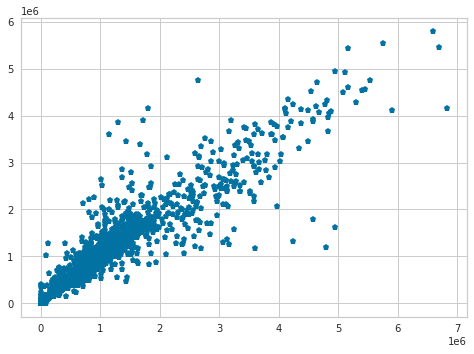

In [74]:
plt.plot(smol.FULLVAL, pred.Label, 'p')